# <center>Прогнозирование **S&P100** на своих предыдущих значениях и курсов входящих в него акций

In [ ]:
# import os
# os.chdir("..")

# %load_ext autoreload
# %autoreload 2

# from dotenv import load_dotenv
# load_dotenv()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS/project1_sp100')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Данные
загрузим ранее подготовленный датасет

In [6]:
path_to_data = "data"

In [7]:
features = pd.read_csv(os.path.join(path_to_data, "sp100.csv"), index_col=0)

In [8]:
features.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,AXP,BA,BAC,BIIB,BK,BKNG,BLK,BMY,BRK.B,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DD,DHR,DIS,DOW,DUK,EMR,EXC,F,FB,...,MDLZ,MDT,MET,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NVDA,ORCL,OXY,PEP,PFE,PG,PM,PYPL,QCOM,RTX,SBUX,SLB,SO,SPG,T,TGT,TMO,TXN,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM,S&P100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-18,0.928013,35.119999,15.150405,15.17,16.000000,1445.000000,24.0625,69.0625,38.4375,64.1250,44.220886,45.0000,24.000000,35.687500,39.617340,355.125,18.000,62.162937,34.000000,438.750000,24.96875,35.0,31.50000,16.166666,42.500,16.937721,51.250,4.3,56.00000,18.000000,44.65625,61.823280,8.363343,34.034248,49.799999,46.687752,30.09375,18.84375,29.812790,38.23,...,31.25,44.3750,13.814617,48.56250,23.000000,70.8125,66.87500,57.65625,21.1875,1.196429,6.328125,3.817708,27.81250,10.538675,36.2500,36.500000,58.46875,49.389999,36.709999,69.53125,19.745123,3.257813,33.06250,14.279787,23.029551,41.1250,34.00000,14.4375,55.187500,7.375000,11.093750,68.6875,23.4375,14.125,52.835213,29.2500,19.4375,65.5625,42.37500,795.679993
2000-01-19,0.951451,35.119999,14.841785,15.17,15.781250,1416.666626,23.5625,72.0000,39.0000,66.8125,43.454998,47.6250,24.000000,40.333332,39.352341,374.625,18.250,60.973213,34.180000,448.125000,24.65625,35.0,30.75000,17.145834,43.375,16.794786,51.875,4.3,56.15625,17.906250,43.96875,61.289555,8.268575,34.280876,49.799999,47.995228,30.84375,19.18750,29.366285,38.23,...,31.25,44.9375,13.814617,49.40625,23.375000,71.5000,67.84375,53.50000,21.6875,1.196429,6.601563,3.781250,28.56250,10.688373,36.4375,37.000000,57.68750,49.389999,36.709999,73.31250,19.096130,3.187500,32.93750,14.623419,23.145567,40.5625,34.96875,14.2500,54.750000,7.437500,10.906250,68.2500,23.0000,14.125,51.823475,30.1875,18.3750,64.0625,42.78125,790.309998
2000-01-20,1.013393,35.119999,14.392884,15.17,15.953125,1404.583374,23.7500,71.8125,40.5000,64.7500,44.175297,46.5000,23.539063,40.895832,38.954845,371.625,17.500,58.891201,34.000000,439.570313,23.56250,35.0,30.96875,16.625000,42.375,16.318338,50.000,4.3,56.18750,16.859375,43.75000,59.680962,8.090883,33.171062,49.799999,48.648964,30.21875,18.90625,28.696527,38.23,...,31.25,44.0000,13.814617,47.56250,22.578125,72.9375,67.40625,53.00000,21.4375,1.196429,6.445313,3.770833,29.62500,10.598555,36.1250,36.390625,56.28125,49.389999,36.709999,77.81250,18.663467,3.132813,32.28125,14.547056,23.261585,41.0000,33.84375,14.5000,56.437500,7.625000,10.500000,68.8750,22.1875,14.125,51.992096,30.1875,18.1875,63.3750,41.84375,783.330017
2000-01-21,0.993862,35.119999,14.000096,15.17,15.718750,1385.833374,23.5000,74.6875,43.1250,62.0625,44.257355,45.6875,22.843750,49.250000,38.557346,381.000,17.375,58.236855,34.220001,423.281250,23.68750,35.0,30.65625,16.541666,41.375,16.270695,48.500,4.3,57.62500,17.250000,44.28125,57.938938,7.806577,32.307877,49.799999,49.248226,30.03125,19.43750,27.717651,38.23,...,31.25,43.5625,13.814617,47.46875,22.000000,72.4375,66.25000,51.87500,22.0000,1.196429,6.335938,3.729167,29.84375,10.388979,36.1250,35.062500,51.34375,49.389999,36.709999,77.46875,19.076464,3.121094,33.00000,14.967050,23.551630,43.0000,32.40625,14.4375,55.398438,7.296875,10.937500,67.2500,21.6875,14.125,54.015572,29.9375,18.3125,62.4375,42.50000,779.780029
2000-01-24,0.948661,35.119999,13.467027,15.17,15.140625,1354.166626,22.8125,69.2500,42.0000,70.1250,44.348534,44.3125,22.281250,45.770832,38.424847,359.625,17.125,55.857414,34.000000,413.906250,22.65625,35.0,30.34375,16.166666,41.125,15.913358,47.000,4.3,54.53125,17.218750,44.40625,59.925587,7.202426,32.862782,49.799999,49.901962,29.06250,20.31250,28.095465,38.23,...,31.25,43.0625,13.814617,46.37500,22.000000,70.2500,64.00000,50.62500,21.8750,1.196429,6.210938,3.562500,27.09375,9.999766,35.3125,34.375000,51.56250,49.389999,36.709999,70.03125,18.879799,3.070313,32.15625,15.348863,23.319595,42.0000,31.75000,14.6250,55.437500,6.898438,10.609375,66.0000,21.4375,14.12

In [9]:
features.shape

(5198, 102)

Первые **4500** строк выделим под **обучение**, остальное - под **валидацию**

In [10]:
TRAIN_SPLIT = 4500

Посмотрим для наглядности на целевую переменную и некоторые курсы акций

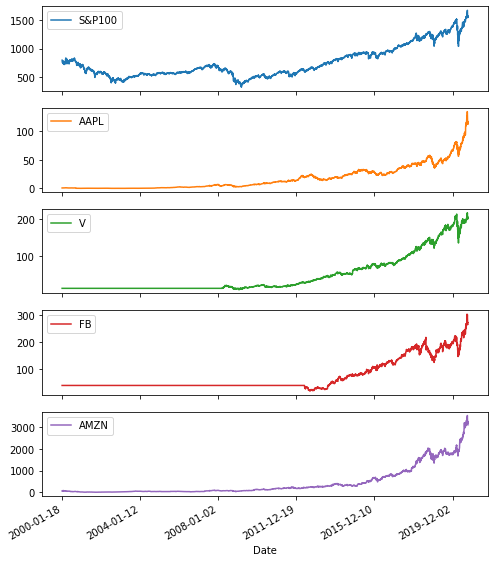

In [11]:
mpl.rcParams['figure.figsize'] = (8, 10)

tickers = ["S&P100", "AAPL", "V", "FB", "AMZN"]
features[tickers].plot(subplots=True);

Стандартизируем (нормализуем) набор данных. Для расчета параметров стандартизации используем только **train**

In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [13]:
dataset = (dataset - data_mean) / data_std

In [14]:
# dataset

Будем делать два варианта прогноза - точечное прогнозирование (одно значение, например - на следующий день) и интервальный прогноз (например - 10 дней вперед, с учетом выходных это будет две недели).    

(Возможно, точечный прогноз будет иметь смысл заменить на классификацию **["buy", ""sell", "hold"]** (или просто ["buy", ""sell"]), иначе по **MSE** не вполне будет наглядно качество )

### Общие параметры

In [15]:
past_history = 90  # смотрим историю за 90 дней (рабочих)
STEP = 1           # данные берем без пропусков

In [16]:
BATCH_SIZE = 64
TARGET_NUM = -1  # номер таргетной фичи в датасете

###  Общие функции

In [17]:
class DatasetCustom(Dataset):
    """
    Кастомный класс датасета
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, key):
        return self.x[key], self.y[key]

In [18]:
def train_model(model, dataloaders, optimizer, num_epochs=3):
    since = time.time()

#     history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#         print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
#             running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, y in dataloaders[phase]:
                inputs = inputs.to(device)
                y = y.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = model.loss(outputs, y.float())

#                     _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            loss_history[phase].append(epoch_loss)
#             history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, loss_history

def test_model(model, testloader):
    n_batches = len(testloader)
    running_loss = 0.0
#     running_corrects = 0

    for inputs, y in tqdm(testloader, total=n_batches):
        inputs = inputs.to(device)
        y = y.to(device)

        outputs = model(inputs)
        loss = model.loss(outputs, y)
#         _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(testloader.dataset)
#     acc = running_corrects.double() / len(testloader.dataset)
    print('Val Loss: {:.4f}'.format(loss))
    return loss

In [19]:
def loss_history_plot(loss_history, title):
    loss = loss_history['train']
    val_loss = loss_history['val']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

In [20]:
def history_predict_plot(history, true_future, prediction, title='', target_num=TARGET_NUM):
  def create_time_steps(length):
    return list(range(-length, 0))
    
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, target_num]), label='History', marker=".")
  plt.plot(np.arange(num_out).flatten() / STEP, np.array(true_future).flatten(), 'go-',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out).flatten() / STEP, np.array(prediction).flatten(), 'rx-',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Функция организации временных интервалов
    """
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels).reshape((len(labels), -1))

## <center>Точечное прогнозирование

In [55]:
future_target = 1  # предсказываем только 1 следующий день

### Сформирум размеченный временной ряд

In [56]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, TARGET_NUM], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, TARGET_NUM],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_train_single.shape, y_train_single.shape

((4410, 90, 102), (4410, 1))

### Создадим загрузчик данных по батчам

In [57]:
train_single_dataset = DatasetCustom(x_train_single, y_train_single)
val_single_dataset = DatasetCustom(x_val_single, y_val_single)

In [58]:
dataloader_train = DataLoader(train_single_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )

dataloader_val = DataLoader(val_single_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True
                            )
len(dataloader_train), len(dataloader_val)

(68, 9)

### Построение модели

Модель будем строить с использованием ячеек **LSTM**

In [64]:
class SP100LstmNet(nn.Module):
    
    def __init__(self, batch_size, predict_num, criterion=None, 
                 input_size=102, seq_len=90, 
                 dropout=0.1, hidden_size =100, num_layers=2, 
                 multi=False
                 ):
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.predict_num = predict_num
        self.criterion = criterion
        self.multi = multi
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, 
                             dropout=dropout, 
                            )
        self.ln1 = nn.LayerNorm([seq_len, hidden_size])
        # self.bn1 = nn.BatchNorm1d(seq_len)
        # последний lstm
        self.lstm_last = nn.LSTM(hidden_size, hidden_size, num_layers, 
                                 dropout=dropout, 
                                )
        self.ln_last = nn.LayerNorm([seq_len, hidden_size])
        # self.bn_last = nn.BatchNorm1d(seq_len)

        self.fc_last = nn.Linear(seq_len * hidden_size, predict_num)

    def forward(self, x):
        chunk_len = x.shape[0]

        
        x = self.lstm1(x.transpose(1, 0).float())[0].transpose(1, 0)  #  change to "batch first", (bs(cl), sl, hs)
        x = self.ln1(x)  # (bs(cl), sl, hs)
        # x = self.bn1(x)  # (bs(cl), sl, hs)

        if self.multi:
            x = self.lstm_last(x.transpose(1, 0).float())[0].transpose(1, 0)  #  change to "batch first", (bs(cl), sl, hs)
            x = self.ln_last(x)  # (bs(cl), sl, hs)
            # x = self.bn_last(x)  # (bs(cl), sl, hs)
        x = x.reshape(chunk_len, self.seq_len * self.hidden_size)
        x = self.fc_last(x)
        return x
    
    def loss(self, outputs, target):
        return self.criterion(outputs, target).mean()

#### Проверим модель на корректность

In [65]:
model = SP100LstmNet(BATCH_SIZE, predict_num=future_target).to(device)

In [66]:
x_, y_ = dataloader_train.__iter__().next()
x_.shape

torch.Size([64, 90, 102])

In [67]:
model(x_.to(device)).shape

torch.Size([64, 1])

### Готовим и тренируем модель

In [73]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmNet(BATCH_SIZE, predict_num=future_target, criterion=nn.MSELoss()).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(model=model, dataloaders=dataloaders, optimizer=optimizer, num_epochs=10)

Epoch 1/10
train Loss: 27.4696
val Loss: 5.0221

Epoch 2/10
train Loss: 12.3173
val Loss: 17.0545

Epoch 3/10
train Loss: 5.3390
val Loss: 7.6983

Epoch 4/10
train Loss: 12.0383
val Loss: 7.1906

Epoch 5/10
train Loss: 3.0681
val Loss: 16.9778

Epoch 6/10
train Loss: 8.9728
val Loss: 30.7260

Epoch 7/10
train Loss: 1.3719
val Loss: 9.6904

Epoch 8/10
train Loss: 1.9630
val Loss: 10.7361

Epoch 9/10
train Loss: 2.9098
val Loss: 1.9376

Epoch 10/10
train Loss: 0.6706
val Loss: 2.7642

Training complete in 0m 26s
CPU times: user 19.3 s, sys: 6.28 s, total: 25.5 s
Wall time: 25.6 s


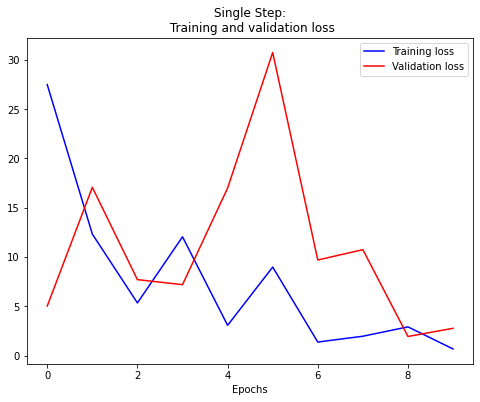

In [74]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Single Step:\n Training and validation loss')

### Примеры прогнозов

In [75]:
# for x, y in list(dataloader_val)[:10]:
#     print(x[:1].to(device).shape)

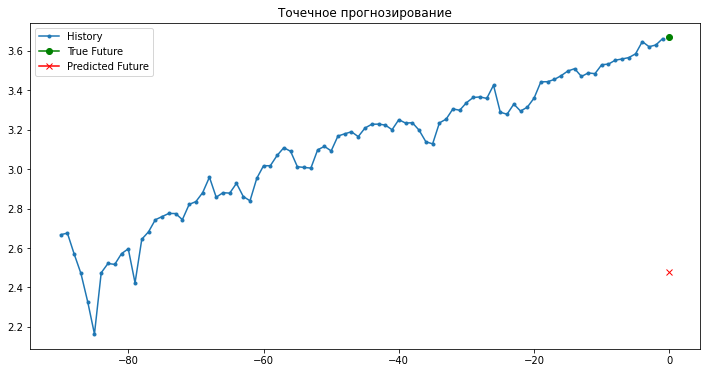

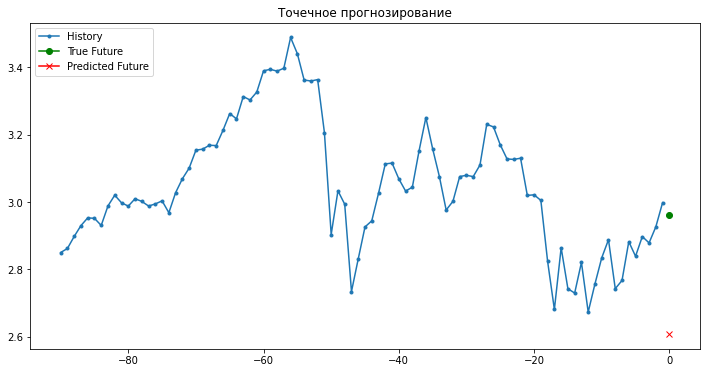

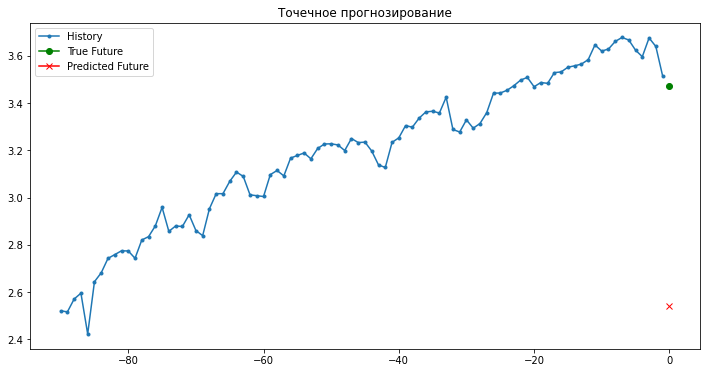

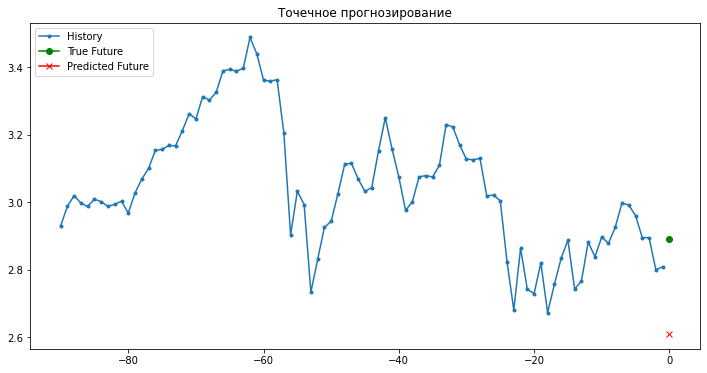

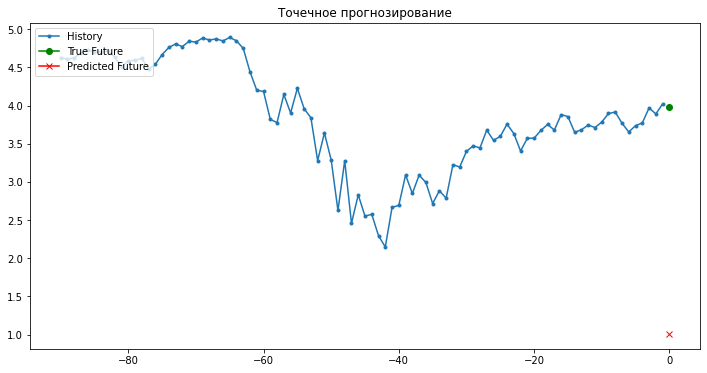

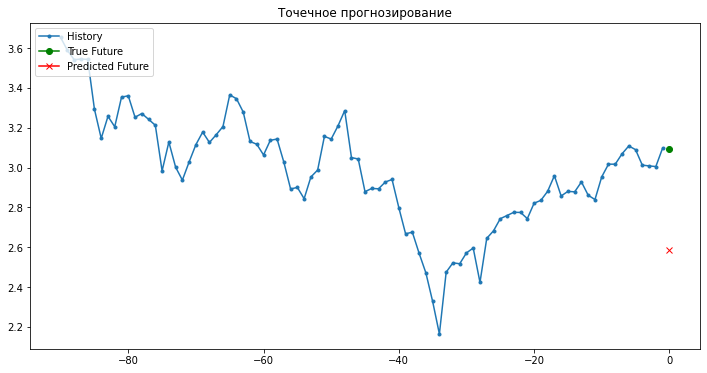

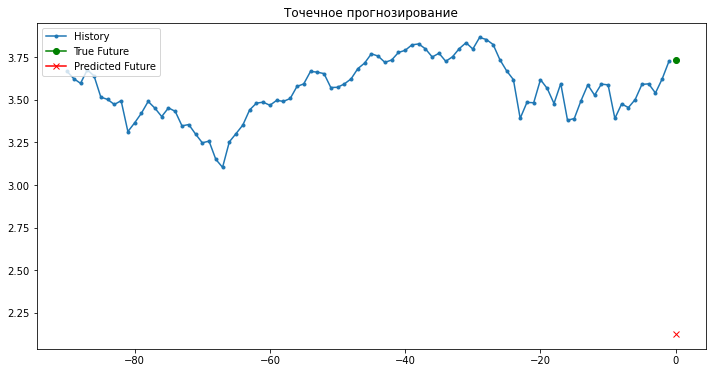

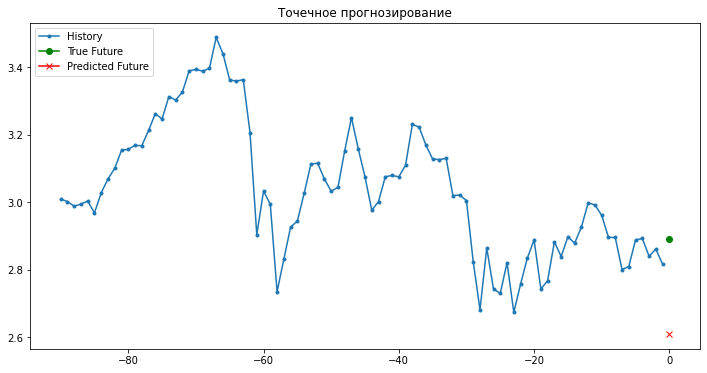

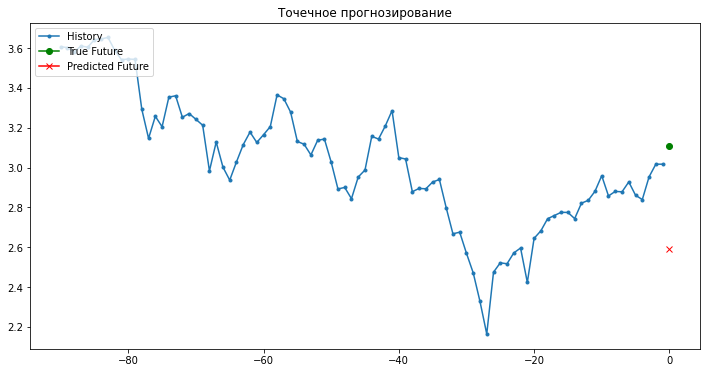

In [78]:
for x, y in list(dataloader_val)[:10]:
  history_predict_plot(x[0], y[0], model(x[:1].to(device)).detach().cpu().numpy(), "Точечное прогнозирование")

## <center>Интервальное прогнозирование
Прогнозирование **интервала** будущих значений

Будем прогнозировать на 10 дней вперед

In [22]:
future_target_multi = 10  # число дней прогнозирований

### Сформирум размеченный временной ряд

In [23]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, TARGET_NUM], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target_multi, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, TARGET_NUM],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target_multi, STEP)
x_train_multi.shape, y_train_multi.shape

((4410, 90, 102), (4410, 10))

### Создадим загрузчик данных по батчам

In [24]:
train_multi_dataset = DatasetCustom(x_train_multi, y_train_multi)
val_multi_dataset = DatasetCustom(x_val_multi, y_val_multi)

In [25]:
train_multi_dataloader = DataLoader(train_multi_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )

val_multi_dataloader = DataLoader(val_multi_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True
                            )

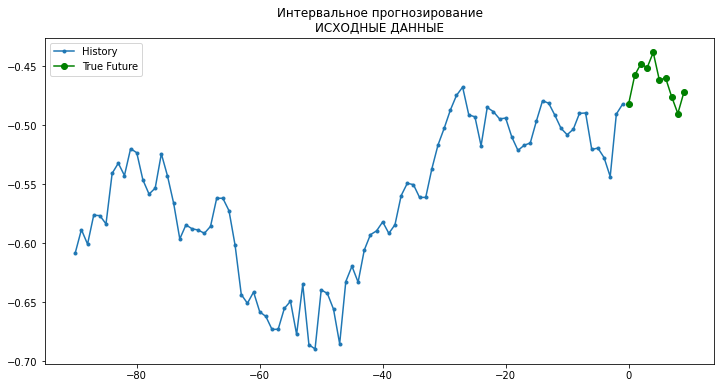

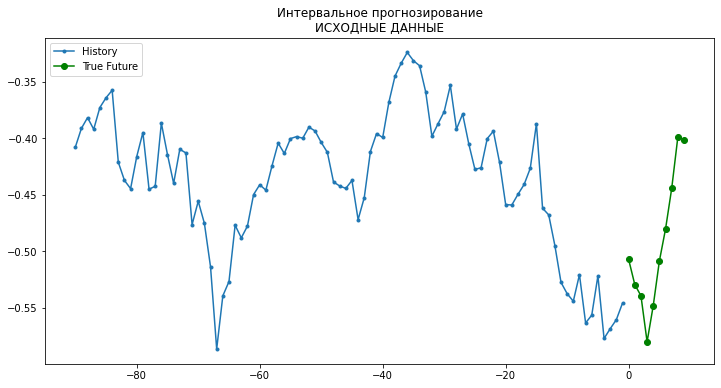

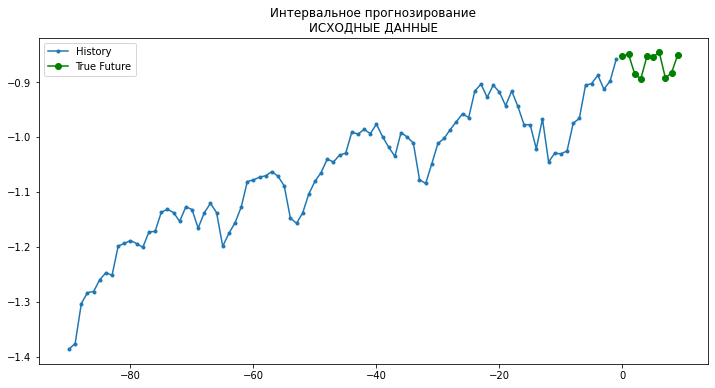

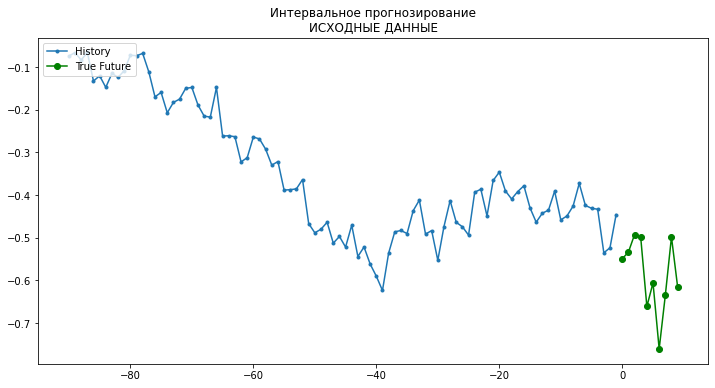

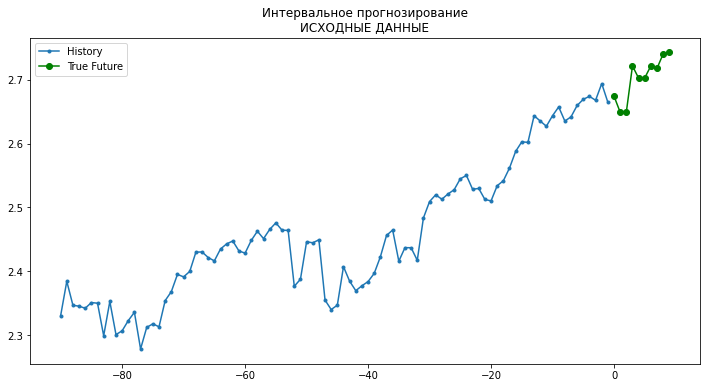

In [26]:
for x, y in list(train_multi_dataloader)[:5]:
    # print(y[0])
    history_predict_plot(x[0], y[0], np.array([0]), "Интервальное прогнозирование\nИСХОДНЫЕ ДАННЫЕ")

### Построение модели
(для построения модели используем уже готовый класс, см. выше)

In [37]:
# class SP100LstmMultiNet(nn.Module):
    
#     def __init__(self, batch_size, predict_num, criterion=None, 
#                  input_size=102, seq_len=90, 
#                  dropout=0.1, hidden_size =100, num_layers=2
#                  ):
#         super().__init__()
#         self.input_size = input_size
#         self.seq_len = seq_len
#         self.batch_size = batch_size
#         self.hidden_size = hidden_size
#         self.predict_num = predict_num
#         self.criterion = criterion
        
#         self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, 
#                              dropout=dropout, 
#                             )
#         self.ln1 = nn.LayerNorm([seq_len, hidden_size])
#         # self.bn1 = nn.BatchNorm1d(seq_len)
#         # последний lstm
#         self.lstm_last = nn.LSTM(hidden_size, hidden_size, num_layers, 
#                                  dropout=dropout, 
#                                 )
#         self.ln_last = nn.LayerNorm([seq_len, hidden_size])
#         # self.bn_last = nn.BatchNorm1d(seq_len)

#         self.fc_last = nn.Linear(seq_len * hidden_size, predict_num)

#     def forward(self, x):
#         chunk_len = x.shape[0]

#         x = self.lstm1(x.transpose(1, 0).float())[0].transpose(1, 0)  #  change to "batch first", (bs(cl), sl, hs)
#         x = self.ln1(x)  # (bs(cl), sl, hs)
#         # x = self.bn1(x)  # (bs(cl), sl, hs)

#         x = self.lstm_last(x.transpose(1, 0).float())[0].transpose(1, 0)  #  change to "batch first", (bs(cl), sl, hs)
#         x = self.ln_last(x)  # (bs(cl), sl, hs)
#         # x = self.bn_last(x)  # (bs(cl), sl, hs)
#         x = x.reshape(chunk_len, self.seq_len * self.hidden_size)
#         x = self.fc_last(x)
#         return x
    
#     def loss(self, outputs, target):
#         return self.criterion(outputs, target).mean()

Проверим нашу модель на корректность 

In [79]:
model_multi = SP100LstmNet(BATCH_SIZE, predict_num=future_target_multi, criterion=nn.MSELoss(), multi=True).to(device)

In [80]:
x, y = val_multi_dataloader.__iter__().next()
print(model_multi(x.to(device)).shape)

torch.Size([64, 10])


#### Готовим и запускаем тренировку модели

In [85]:
%%time

dataloaders_multi = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model_multi = SP100LstmNet(BATCH_SIZE, predict_num=future_target_multi, criterion=nn.MSELoss(), 
                           dropout=0.2, hidden_size=100, num_layers=2, 
                           multi=True
                           ).to(device)
optimizer_multi = torch.optim.Adadelta(model_multi.parameters())

model_multi, loss_history_multi = train_model(model=model_multi, dataloaders=dataloaders_multi, optimizer=optimizer_multi, num_epochs=12)

Epoch 1/12
train Loss: 46.9783
val Loss: 12.3237

Epoch 2/12
train Loss: 19.2483
val Loss: 25.7516

Epoch 3/12
train Loss: 3.0377
val Loss: 13.0664

Epoch 4/12
train Loss: 13.5772
val Loss: 12.2576

Epoch 5/12
train Loss: 3.1857
val Loss: 6.9746

Epoch 6/12
train Loss: 11.1537
val Loss: 9.8315

Epoch 7/12
train Loss: 1.7852
val Loss: 8.7898

Epoch 8/12
train Loss: 3.4132
val Loss: 9.2463

Epoch 9/12
train Loss: 0.7882
val Loss: 8.9392

Epoch 10/12
train Loss: 1.0638
val Loss: 14.4035

Epoch 11/12
train Loss: 0.9098
val Loss: 12.6337

Epoch 12/12
train Loss: 0.5299
val Loss: 10.6628

Training complete in 0m 59s
CPU times: user 43.7 s, sys: 15.4 s, total: 59.2 s
Wall time: 59.3 s


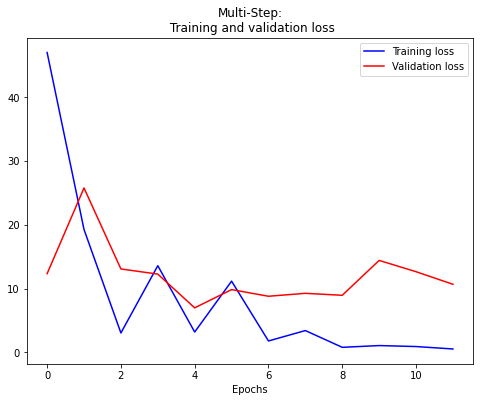

In [86]:
loss_history_plot(loss_history_multi, 'Multi-Step:\n Training and validation loss')

### Примеры интервального прогноза на валидационных данных

In [87]:
# for x, y in list(val_multi_dataloader)[:1]:
#     print(x[0].numpy().shape, y[0].numpy().shape, model_multi(x[:1].to(device)).detach().cpu().numpy())

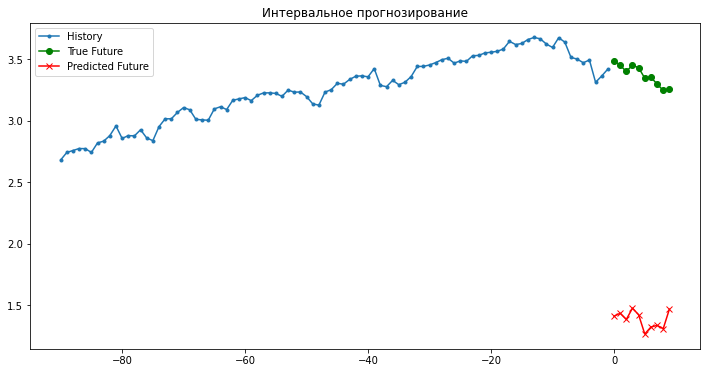

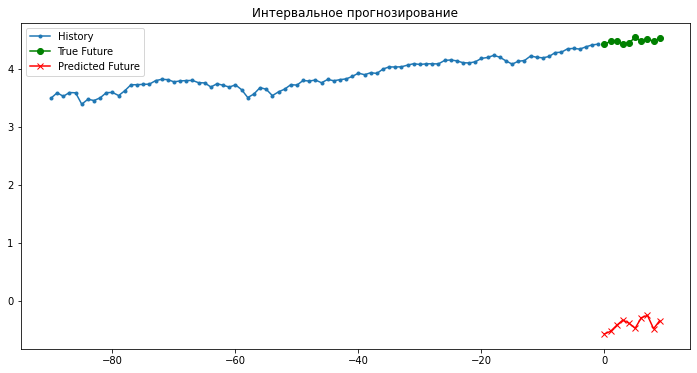

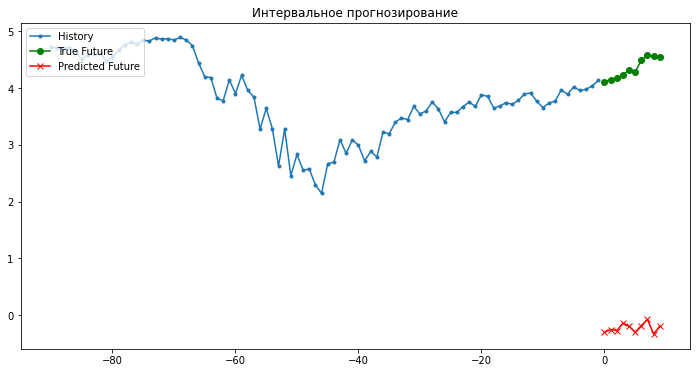

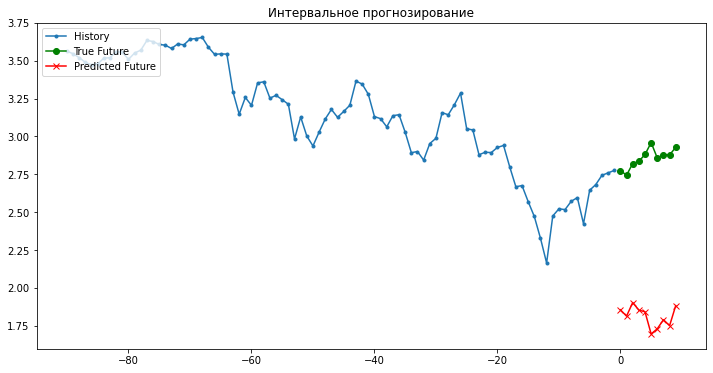

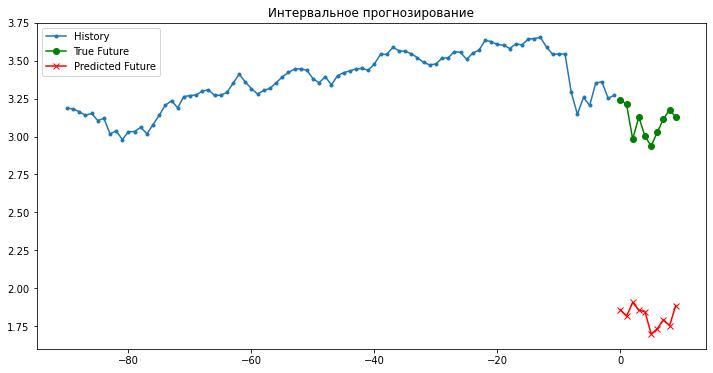

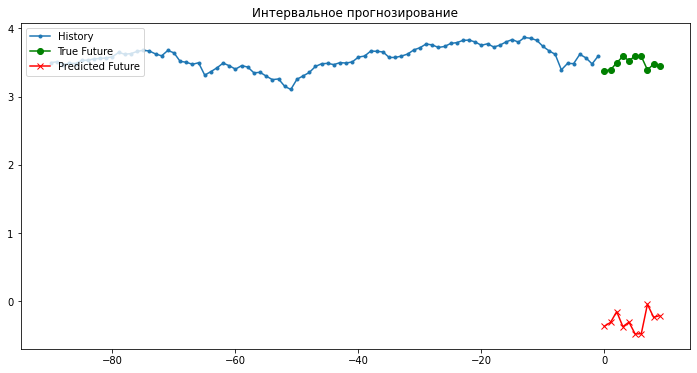

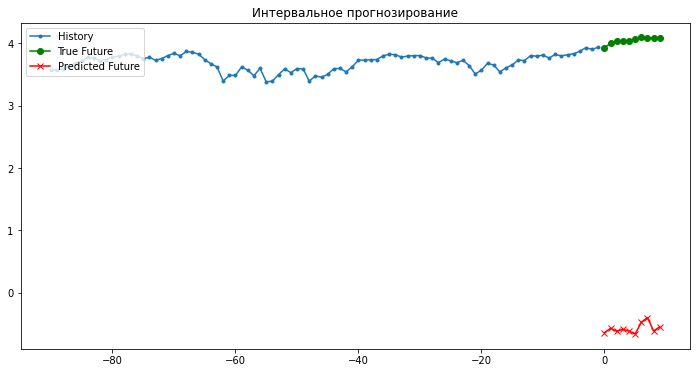

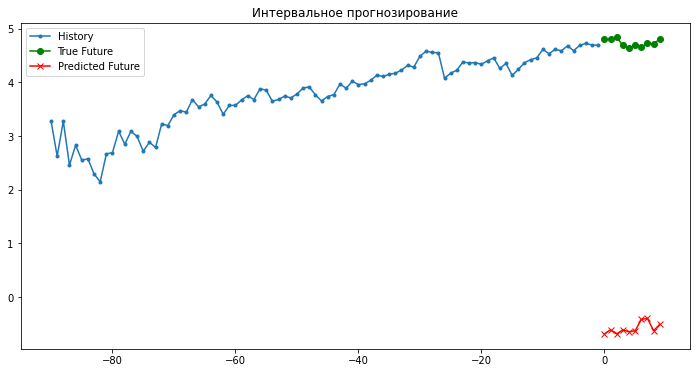

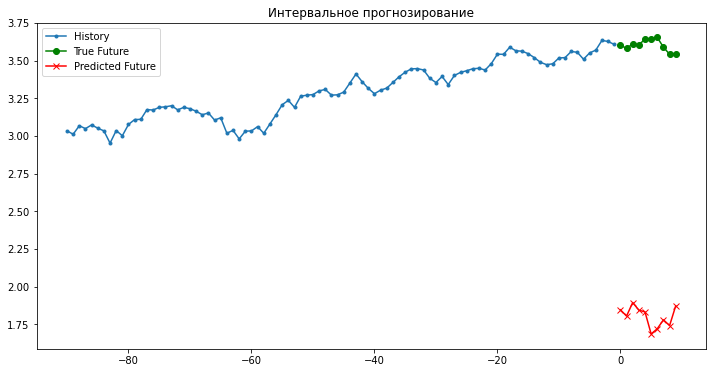

In [88]:
for x, y in list(val_multi_dataloader)[:10]:
  history_predict_plot(x[0].numpy(), y[0].numpy(),
                       model_multi(x[:1].to(device)).detach().cpu().numpy(), "Интервальное прогнозирование")